<a href="https://colab.research.google.com/github/ariel-hedvat/AdvancedMLDLCourseAssignments/blob/main/Assignment%20II%20-%20NLP/Assignment_II_Group_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1><font size=6>Assignment 2 : NLP : Seinfeld or Friends?</font></h1>

  <u>Group members:</u><br>
  - Ariel Hedvat<br>
  - Shiraz Israeli<br>
  - Yuval Bakirov<br>
  - Eitan Bakirov

<br>

This project aims to distinguish dialogue lines from the TV shows Seinfeld and Friends. The dataset includes dialogue text, character information, and show labels. The goal is to build a model trained on dialogues of characters and classifies whether a new dialogue is from Seinfeld or Friends, then evaluate its accuracy on a test set.<br>
Also, we explore the results of the model on each character.
</div>


<div class="markdown-google-sans">
  <h1><font size=5>Data</font></h1>
</div>

The dataset comprises five columns: <br>
- Dialogue - indicating spoken lines<br>
- Character - denoting the speaker <br>
- Episode - specifying the episode number <br>
- Show - identifying the television series <br>
- Dialogue_length - quantifying the length of each dialogue entry.<br><br>

In our model we will only use the features: "Dialouge" (Sample) and "Show" (Label) during the training.<br><br>

<div class="markdown-google-sans">
  <h1><font size=5>Table of Contents</font></h1>

>[Import Libraries](#scrollTo=-_VBJ0JlYLKI)

>[Loading the data](#scrollTo=kXwOL606ZfUN)

>[EDA & Pre- Processing](#scrollTo=P8cTl07AZgyg)

>>[Text cleaning](#scrollTo=YahuK9cqYcyC)

>>[Special character removal](#scrollTo=rktALPaIYimc)

>>[Stop words removal](#scrollTo=oI-pgoYYYnZe)

>>[Stemming](#scrollTo=Tdei7JlEc_Ea)

>>[Train-Test-Validation split](#scrollTo=mG1TBityfg1-)

>>[Labeling](#scrollTo=EIruMKat5Rx3)

>>[Text tokenization](#scrollTo=Qcz-Ji7ovJWt)

>>[Sequence padding](#scrollTo=V7kY5N9Hw-31)

>[Modeling](#scrollTo=_58J58NQVpBV)

>[Explore Our results](#scrollTo=vbjiKHyi7Irm)

>>[Visualization](#scrollTo=gj5MAByiQRWi)

>>[Word Cloud For Each Show](#scrollTo=hZ78JqH4P6Kk)

>[Output](#scrollTo=IJrSf6hnWnCJ)



#  Import Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
from sklearn.model_selection import train_test_split

!pip install contractions
import contractions

from bs4 import BeautifulSoup
import re
from sklearn.preprocessing import LabelBinarizer

import nltk
from nltk.tokenize.toktok import ToktokTokenizer

from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer

from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding, MaxPooling1D, BatchNormalization

from keras.models import Sequential
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# Loading the data

In [2]:
# Data Loading for Train
url = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/Assignment%20II%20-%20NLP/train.csv'
full_train_data = pd.read_csv(url)

In [3]:
# Data Loading for Test
url_test = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/Assignment%20II%20-%20NLP/test.csv'
full_test_data = pd.read_csv(url_test)

# **EDA & Pre- Processing**

First, let's look at our data:

In [4]:
full_train_data

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13
...,...,...,...,...,...
70400,Pretty much.,jerry,S05E09,Seinfeld,2
70401,"Oh, well um, not right now. Y'know I’m just g...",phoebe,Season-03 Episode-05-The One With Frank Jr.,Friends,22
70402,"Ooh, I think I wanna trade circles.",phoebe,Season-07 Episode-22-The One With Chandler’s Dad,Friends,7
70403,"Hey, hey, what is this? What's going on here?",jerry,S05E03,Seinfeld,9


Before moving on looking at the data, let's check for missing values:

In [5]:
# Train set
missing_values_count = full_train_data.isnull().sum()
print("Missing values count per column in train data:")
print(missing_values_count)

Missing values count per column in train data:
Dialogue           0
Character          0
Episode            0
Show               0
Dialogue_length    0
dtype: int64


In [6]:
# Test set
missing_values_count = full_test_data.isnull().sum()
print("Missing values count per column in test data:")
print(missing_values_count)

Missing values count per column in test data:
Dialogue           0
Character          0
Episode            0
Show               0
Dialogue_length    0
dtype: int64


No missing values found!

Checking whether the train data is balanced:

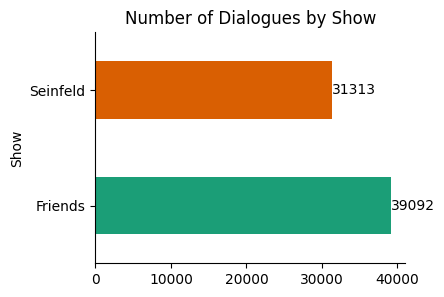

In [7]:
# Grouping by 'Show' and getting size
grouped_data = full_train_data.groupby('Show').size()

plt.figure(figsize=(4, 3))  # Adjust width and height as needed

# Plotting the grouped data
ax = grouped_data.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding count numbers near the plots with slight adjustments
for i, count in enumerate(grouped_data):
    ax.text(count + 0.1, i, str(count), va='center', ha='left')

# Adding title
plt.title("Number of Dialogues by Show")

plt.show()

In [8]:
# Display the character count per show
full_train_data.groupby('Show')['Character'].nunique()

Show
Friends     6
Seinfeld    4
Name: Character, dtype: int64

Looks like "Friends" has sligthly more dialouges than "Seinfeld", but overall it looks pretty balanced. <br>
(Based on the fact that in Friends show there are more characters than in Seinfeld - 6 vs 4)

Therefore we are expecting to see better results for "Friends" since there are more samples to learn from.

In [9]:
# Dialouge exmaple
full_train_data.iloc[1, 0]

' (to Joey) Are you gonna be embarrassed going up there having nothing prepared?'

Let's look at the number of dialogues each character has in its show:

In [10]:
# Define a function to plot histogram with count numbers
def plot_histogram_with_counts(ax, data, title, xlabel, ylabel, color):
    bars = ax.bar(data.index, data.values, color=color)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(data.index)
    ax.set_xticklabels(data.index, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    # Adding count numbers above each column
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom')


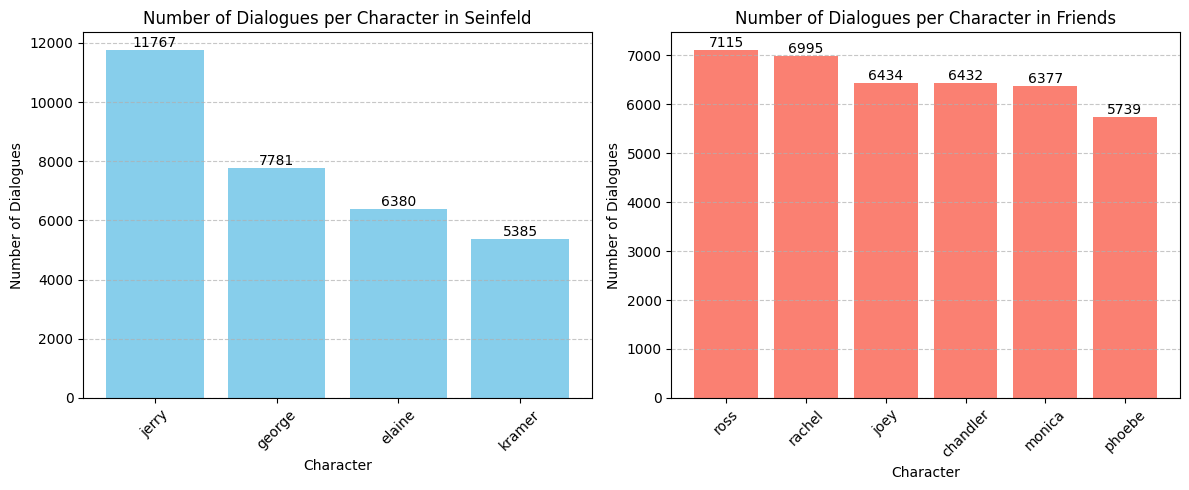

In [11]:
# Filter data for Seinfeld
seinfeld_df = full_train_data[full_train_data['Show'] == 'Seinfeld']
# Group by character and count dialogues
seinfeld_character_counts = seinfeld_df['Character'].value_counts()
seinfeld_characters = seinfeld_character_counts.index.tolist()

# Filter data for Friends
friends_df = full_train_data[full_train_data['Show'] == 'Friends']
# Group by character and count dialogues
friends_character_counts = friends_df['Character'].value_counts()
friends_characters = friends_character_counts.index.tolist()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for Seinfeld
plot_histogram_with_counts(axes[0], seinfeld_character_counts, 'Number of Dialogues per Character in Seinfeld', 'Character', 'Number of Dialogues', 'skyblue')

# Plot histogram for Friends
plot_histogram_with_counts(axes[1], friends_character_counts, 'Number of Dialogues per Character in Friends', 'Character', 'Number of Dialogues', 'salmon')

plt.tight_layout()
plt.show()

We can see that: <br>
Seinfeld - Jerry has much more dialogues than the others. <br>
Friends - the number of dialogues is more balanced.

In [12]:
# Dialogues Length Distribution
# Plotting the distribution of dialogue lengths for each show to understand the typical length of dialogues
def plot_dialogue_length_distribution(data, show_names):
    plt.figure(figsize=(10, 6))

    for show_name in show_names:
        show_data = data[data['Show'] == show_name]
        dialogue_lengths = show_data['Dialogue'].apply(lambda x: len(x.split()))
        plt.hist(dialogue_lengths, bins=30, alpha=0.5, label=show_name)

    plt.title('Dialogue Length Distribution Comparison')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.legend()
    plt.show()

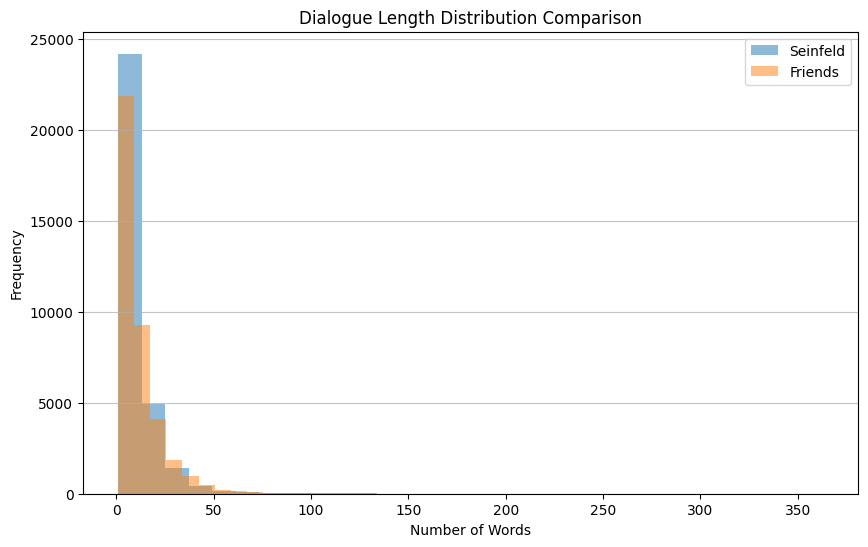

In [13]:
plot_dialogue_length_distribution(full_train_data, ['Seinfeld', 'Friends'])

We can see that most of the sentences are short at both shows.

In [14]:
# Function that finds the most common words
def count_words_custom(col):
    # Create an empty dictionary to store word counts
    word_counts = {}

    # Iterate over each row in the column
    for row in col:
        # Convert dialogue to lowercase and split into words
        words = row.lower().split()

        # Iterate over each word in the row
        for word in words:
            # Update word count dictionary
            word_counts[word] = word_counts.get(word, 0) + 1

    # Sort word counts by value in descending order
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # Extract top 20 words and their counts
    top_words = [word for word, count in sorted_word_counts[:20]]
    top_counts = [count for word, count in sorted_word_counts[:20]]

    # Plot bar chart
    plt.figure(figsize=(15, 5))
    plt.bar(top_words, top_counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 20 Most Common Words')
    plt.xticks(rotation=45)
    plt.show()

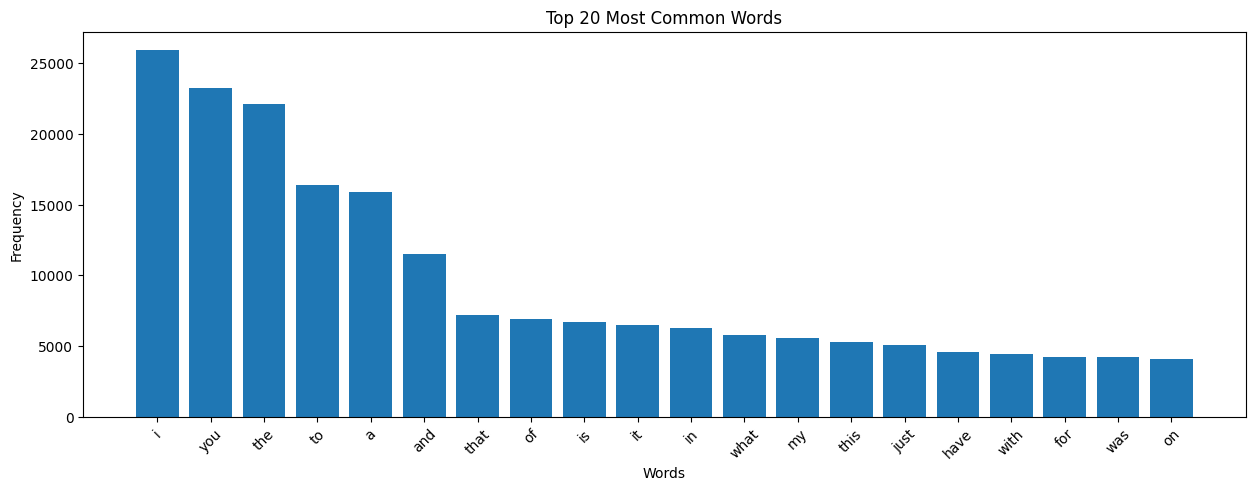

In [15]:
count_words_custom(full_train_data['Dialogue'])

We can see that all the most common words are Stop Words. We want to see the frequency without them.

For that we will implement data preprocessing steps:

## Text cleaning

In [16]:
# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [17]:
# Expanding contractions
def expand_contractions(text):
    return(contractions.fix(text))

In [18]:
# A function for removing special characters and expanding contractions
def clean_text(text):
  text = remove_between_square_brackets(text)
  text = expand_contractions(text)
  return text

In [19]:
# Apply function on 'Dialogue' column
full_train_data['Dialogue'] = full_train_data['Dialogue'].apply(clean_text)
full_test_data['Dialogue'] = full_test_data['Dialogue'].apply(clean_text)

In [20]:
full_train_data.iloc[1, 0]

' (to Joey) Are you going to be embarrassed going up there having nothing prepared?'

## Special character removal

In [21]:
# Define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

In [22]:
# Apply function on Dialogue column
full_train_data['Dialogue'] = full_train_data['Dialogue'].apply(remove_special_characters)
full_test_data['Dialogue'] = full_test_data['Dialogue'].apply(remove_special_characters)

In [23]:
full_train_data.iloc[1, 0]

' to Joey Are you going to be embarrassed going up there having nothing prepared'

## Stop words removal

We will use the NLTK in order to find all the English stop words and take a look at a few of them:

In [24]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
print('Number of English stop words:', len(stopword_list))
print(stopword_list[:5])

Number of English stop words: 179
['i', 'me', 'my', 'myself', 'we']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
# Adding a progress bar to the output
tqdm.pandas()

# Function that removes the stop words from a given text
def remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [26]:
# Apply function on Dialogue column
full_train_data['Dialogue'] = full_train_data['Dialogue'].progress_apply(remove_stopwords)
full_test_data['Dialogue'] = full_test_data['Dialogue'].progress_apply(remove_stopwords)

  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

In [27]:
full_train_data.iloc[1, 0]

'Joey going embarrassed going nothing prepared'

Now we can run the word count again and see the desired plotting:

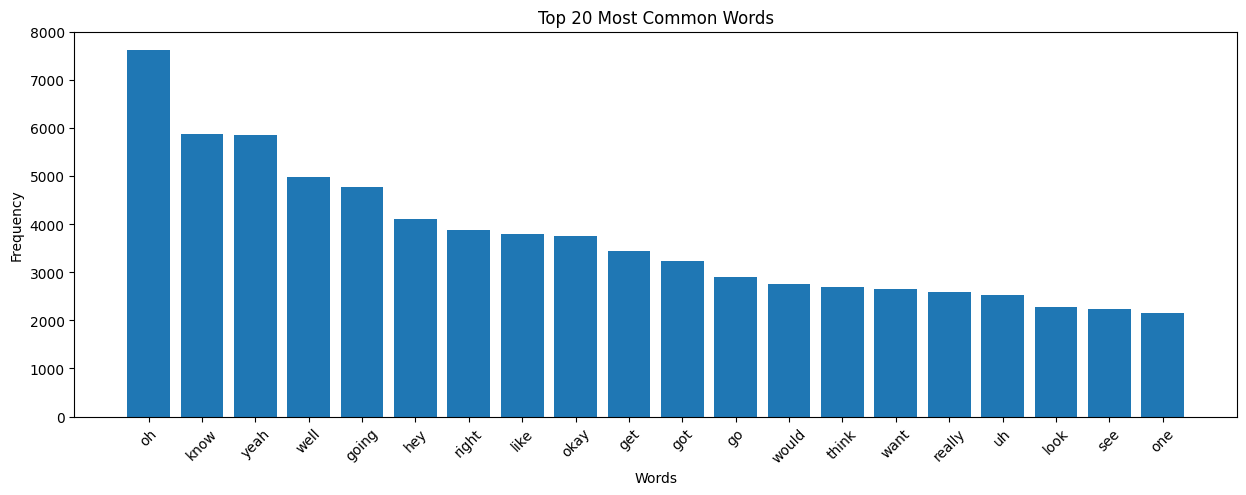

In [28]:
count_words_custom(full_train_data['Dialogue'])

Now we can see that there are no more stop words from the english corpus left.

## Stemming

In [29]:
# Stemming the text
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [30]:
# Apply function on Dialogue column
full_train_data['Dialogue'] = full_train_data['Dialogue'].progress_apply(simple_stemmer)
full_test_data['Dialogue'] = full_test_data['Dialogue'].progress_apply(simple_stemmer)

  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

In [31]:
full_train_data.iloc[1, 0]

'joey go embarrass go noth prepar'

## Train-Test-Validation split

In [32]:
X_train = full_train_data['Dialogue']
X_test = full_test_data['Dialogue']
y_train = full_train_data['Show']
y_test = full_test_data['Show']

In [33]:
# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('\nx_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('\nx_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

x_train shape: (56324,)
y_train shape: (56324,)

x_test shape: (4245,)
y_test shape: (4245,)

x_val shape: (14081,)
y_val shape: (14081,)


## Labeling

We will change the labels "Friends" and "Seinfeld" to 1 and 0 accordingly:

In [34]:
# Making sure that there are only two unique labels
unique_shows = full_train_data['Show'].unique()
print("Unique values in the 'show' column:")
print(unique_shows)

Unique values in the 'show' column:
['Friends' 'Seinfeld']


As we saw above - we have only 2 values in 'Show' columns : Friends and Seindfeld. <br>
Therefore we will change our lable into binary numbers : Seinfeld = 0 , Friends = 1

In [35]:
custom_labels = ['Seinfeld', 'Friends']

# Initialize LabelBinarizer
lb = LabelBinarizer()

# Fit and transform custom labels
binary_labels = lb.fit_transform(custom_labels)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

## Text tokenization

For our deep learning model we will convert the text data into a suitable format of data (numeric form) using the Keras' tokenizer:

In [36]:
token = Tokenizer(lower=False)
token.fit_on_texts(X_train)

In [37]:
X_train_before_token = X_train

In [38]:
X_train = token.texts_to_sequences(X_train)
X_val = token.texts_to_sequences(X_val)
X_test = token.texts_to_sequences(X_test)

Before:

In [39]:
X_train_before_token[1]

'joey go embarrass go noth prepar'

After:

In [40]:
token.texts_to_sequences([X_train_before_token[1]])

[[35, 1, 607, 1, 99, 1282]]

## Sequence padding

In order to train our Neural Network, we need the dataset to be with a fixed amount of features (in our case - words\tokens). Thus, we will apply padding  on the data.

Calculate dialouge lengths:

In [41]:
# Calculate the dialouge length
dialouge_len_list = [len(dialouge) for dialouge in X_train]

print ("Longest dialouge:", max(dialouge_len_list))
print("Shortet dialouge: ", min(dialouge_len_list))
print("Average dialouge:", np.mean(dialouge_len_list))

Longest dialouge: 166
Shortet dialouge:  0
Average dialouge: 5.3504012499112275


Let's examine the distribution:

<Axes: ylabel='Count'>

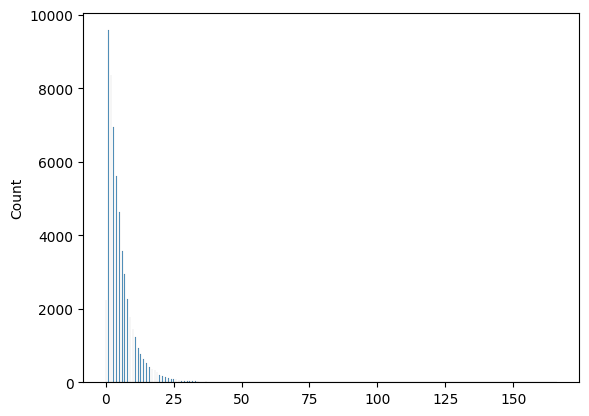

In [42]:
sns.histplot(dialouge_len_list)

We want to make sure that all dialouges have the same length. According to the distribution, 40 seems like a reasonable shared value:

In [43]:
max_words = 40

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

Let's see what a sample look like:

In [44]:
X_train.shape

(56324, 40)

In [45]:
X_train[10, :]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,  268,  247,  340,  834,
          3, 4205, 4885,  159,    3,   52,  340], dtype=int32)

In [46]:
total_words = len(token.word_index) + 1
print("Number of unique words in both shows after preprocessing:", total_words)

Number of unique words in both shows after preprocessing: 15576


# Modeling

Let's build the architecture:

 Building an architecture of a convolutional neural network (CNN) implemented using Keras. <br>
After having experiments with the model architecture we found that the best one consists : <br>
a Sequential model to define a linear stack of layers, <br>
 an Embedding Layer that converts input integer sequences into dense vectors,  <br>
 two Conv1D layers with different filter sizes and activation functions to capture local patterns in the text, <br>
 a Flatten Layer to prepare the output for the dense layers, <br>
Dense Layers with ReLU activation and a Dropout layer to prevent overfitting,
<br> and a final Dense layer with sigmoid activation for binary classification.
<br> The model is compiled using binary crossentropy loss and Adam optimizer, which adjusts learning rates for each parameter.

In [47]:
# Define the model
model = Sequential()
embedding_dimension = 32
model.add(Embedding(input_dim=total_words, output_dim=embedding_dimension, input_length=max_words))
model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
loss_function = 'binary_crossentropy'
model_optimizer = 'adam'
model.compile(loss=loss_function, optimizer=model_optimizer, metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 32)            498432    
                                                                 
 conv1d (Conv1D)             (None, 40, 16)            1552      
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           6272      
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense (Dense)               (None, 128)               655488    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [48]:
# Get the number of trainable parameters
trainable_params = model.count_params()

print("Number of Trainable Parameters:", trainable_params)

Number of Trainable Parameters: 1161873


In [49]:
num_of_epochs = 2
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epochs, batch_size=64)

Epoch 1/2
881/881 [==============================] - 32s 34ms/step - loss: 0.5332 - accuracy: 0.6957 - val_loss: 0.4964 - val_accuracy: 0.7220
Epoch 2/2
881/881 [==============================] - 21s 24ms/step - loss: 0.4318 - accuracy: 0.7730 - val_loss: 0.4963 - val_accuracy: 0.7337


In [50]:
# Accessing the training accuracy from the history object
train_accuracy = history.history['accuracy'][-1]
print("Training Set Accuracy:", train_accuracy)

Training Set Accuracy: 0.7730452418327332


In [51]:
# Get the number of layers in the model
num_layers = len(model.layers)
print("Number of Layers:", num_layers)

Number of Layers: 7


Let's evaluate our model:

In [52]:
best_model_accuracy = model.evaluate(X_test, y_test)[1]
print("Model evaluation (accuracy):", best_model_accuracy)

133/133 [==============================] - 1s 4ms/step - loss: 0.3696 - accuracy: 0.8382
Model evaluation (accuracy): 0.8381625413894653


# Explore Our results

## Visualization

Let's visalize the accuracy for each of the characters for every show:

In [53]:
# Define a function to calculate accuracy for each character
def evaluate_accuracy_for_character(y_pred_probs, test_df, character):

    # Flatten y_test
    y_test_flat = y_test.flatten()

    # Put 0 & 1 instead of Friends & Seinfeld
    test_df['Show'] = y_test_flat

    # Filter test data by character
    character_test_df = test_df[test_df['Character'] == character]

    # Get true labels for the character
    y_character_test = character_test_df['Show']

    # Filter predictions for the character
    character_indices = character_test_df.index
    y_character_pred_probs = y_pred_probs[character_indices]

    # Convert probabilities to binary labels
    y_character_pred = (y_character_pred_probs >= 0.5).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(y_character_test, y_character_pred)
    return accuracy

In [54]:
# Function that returns a sorted list of the accuracies of all the characters
def get_model_accuracy_by_character(model, characters, X_test, full_test_data):

  # Predict probabilities for all characters
  y_pred_probs = model.predict(X_test)

  # Dictionary to store accuracy for each character
  character_accuracy = {}

  # Evaluate accuracy for each character
  for character in characters:
      accuracy = evaluate_accuracy_for_character(y_pred_probs, full_test_data, character)
      character_accuracy[character] = accuracy

  sorted_character_accuracy = dict(sorted(character_accuracy.items(), key=lambda item: item[1], reverse=True))
  return sorted_character_accuracy

In [55]:
def plot_histogram_by_model(sorted_character_accuracy, seinfeld_characters, friends_characters):
    # Define colors for each show
    seinfeld_color = 'skyblue'
    friends_color = 'salmon'

    # Plotting results
    plt.figure(figsize=(10, 6))

    for character, accuracy in sorted_character_accuracy.items():
        # Determine the color based on the character's show
        color = seinfeld_color if character in seinfeld_characters else friends_color

        # Plot the bar with the appropriate color
        plt.bar(character, accuracy, color=color)

        # Annotate the bar with the accuracy value
        plt.text(character, accuracy, f'{accuracy:.2f}', ha='center', va='bottom')

    plt.title('Accuracy for Each Character')
    plt.xlabel('Character')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)

        # Create legend
    friends_patch = plt.Rectangle((0,0),1,1,fc=friends_color, edgecolor = 'none')
    seinfeld_patch = plt.Rectangle((0,0),1,1,fc=seinfeld_color, edgecolor = 'none')
    plt.legend([friends_patch, seinfeld_patch], ['Friends', 'Seinfeld'], loc='upper right')

    plt.show()

In [56]:
def histogram_accuracy_prediction_by_character(model, X_test, full_test_data, seinfeld_characters, friends_characters):

  # List of characters
  characters = full_test_data['Character'].unique()

  # Getting the results for each character
  sorted_character_accuracy = get_model_accuracy_by_character(model, characters, X_test, full_test_data)

  # Plotting histogram accordingly
  plot_histogram_by_model(sorted_character_accuracy, seinfeld_characters, friends_characters)

133/133 [==============================] - 1s 3ms/step


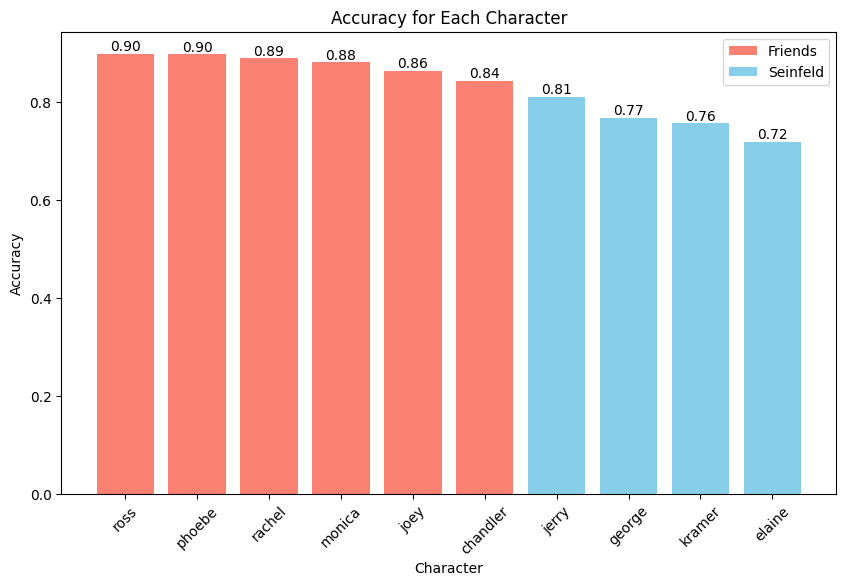

In [57]:
histogram_accuracy_prediction_by_character(model, X_test, full_test_data, seinfeld_characters, friends_characters)

We can see that indeed, as we expected, the characters of Friends had a better accuracy overall than the characters of Seinfeld.

Overall all the accuracies are pretty high and show that our model has good predictions.

## Word Cloud For Each Show

In [58]:
def word_cloud_function(df, X_test, model, show):

    y_pred_probs = model.predict(X_test)

    # Get the predicted classes (0 for Friends, 1 for Seinfeld)
    predicted_classes = (y_pred_probs > 0.5).astype(int)

    # Add predicted_classes as a column to the existing DataFrame df
    df['Predicted_Class'] = predicted_classes.flatten()

    # Filter dialogues for the specified show
    if show == 'Seinfeld':
        dialogues = df[df['Predicted_Class'] == 1]['Dialogue'].values
        title = 'Seinfeld Word Cloud'
    elif show == 'Friends':
        dialogues = df[df['Predicted_Class'] == 0]['Dialogue'].values
        title = 'Friends Word Cloud'
    else:
        print("Invalid show. Please enter 'Seinfeld' or 'Friends'.")
        return

    # Join all dialogues from the specified show into a single string
    text = ' '.join(dialogues)

    # Create a WordCloud object for the specified show
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

    # Plot the WordCloud for the specified show
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

133/133 [==============================] - 1s 4ms/step


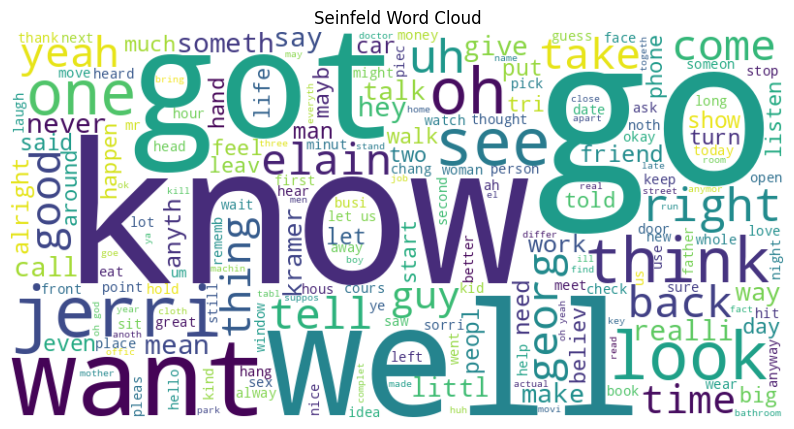

133/133 [==============================] - 1s 4ms/step


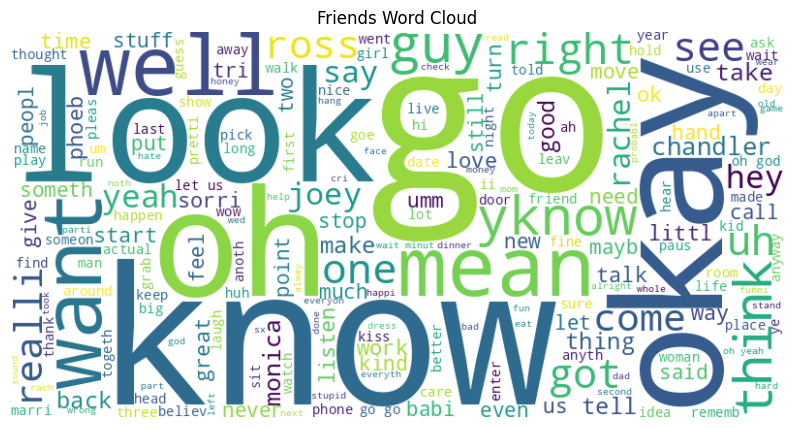

In [59]:
word_cloud_function(full_test_data, X_test, model, 'Seinfeld')
word_cloud_function(full_test_data, X_test, model, 'Friends')

# **Output**



In [60]:
results = {'Test Set Accuracy': [best_model_accuracy],
           'Train Set Accuracy': [train_accuracy],
           'Number of trainable parameters': [trainable_params],
           'Number of layers': [num_layers],
           'Regularization methods': ['Dropout'],
           'Number of epochs': [num_of_epochs],
           'Choice of loss function': [loss_function],
           'Choice of optimizer': [model_optimizer],
           'Embedding dimension': [embedding_dimension]
           }
df = pd.DataFrame(results)

In [61]:
df

,Test Set Accuracy,Train Set Accuracy,Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Choice of loss function,Choice of optimizer,Embedding dimension
0,0.838163,0.773045,1161873,7,Dropout,2,binary_crossentropy,adam,32


In [62]:
from google.colab import files
df.to_csv(os.path.join(os.getcwd(), 'exercise3.csv'))
files.download('exercise3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>